In [12]:
%load_ext autoreload
%autoreload 2
from sigcom.it.util import getMutualInfo, mutual_information_magic
from sigcom.tx.util import generate_bits
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
getMutualInfo(.5)

array([ 0.08521319])

System model
$$r=t+n$$
L-value
$$L(b)=\log\frac{p(0|r)}{p(1|r)}=2\cdot SNR\cdot r$$

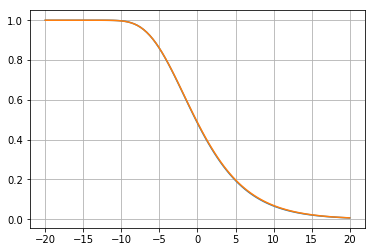

In [44]:
N = 100000
noise = np.random.randn(N)
bits = generate_bits(N)
tx = 1-2*bits
Ps_dB = np.linspace(-20,20,100)
MIs = []
for P_dB in Ps_dB:
    P = 10**(P_dB/10)
    rx = tx + noise * np.sqrt(P)
    Llrs = 2/P*rx
    MI = mutual_information_magic(Llrs, bits, 1)
    MIs.append(MI)
plt.plot(Ps_dB, MIs)
P_ch = 4/10**(Ps_dB/10)
plt.plot(Ps_dB, getMutualInfo(P_ch))
plt.grid()
plt.show()

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sigcom.coding.atsc import pck_long
from sigcom.coding.atsc.bititlv_long import bititlv_long
from sigcom.coding.util import get_layerwise_pck, layerwise_pcks_to_PCM

M = 4
ldM = int(np.log2(M))
code_rate_id = [8,15]

code = pck_long.get_pck(code_rate_id)
layerwise_pck, _ = get_layerwise_pck(code, True)
H = layerwise_pcks_to_PCM(layerwise_pck, code)
bil = bititlv_long(M,code_rate_id)
H_sum = H.sum(axis=0)
H_sum = np.squeeze(np.array(H_sum, dtype=np.int32))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
a, b = np.unique(H_sum[bil], return_counts=True)
print(a)
print(b/64800)

[ 1  2  3  4 19]
[  1.54320988e-05   4.66651235e-01   3.33333333e-01   8.88888889e-02
   1.11111111e-01]


In [169]:
m = H_sum[bil].reshape(-1,ldM)
H_sum_encoded = np.dot(m, [1,np.max(m)])
H_sum_encoded_unique, index, count = np.unique(H_sum_encoded, return_counts=True, return_index=True)
dv_at_demapper_input = [m[i,:] for i in index]

In [91]:
v = H_sum[bil]
w = []
for i in range(int(len(v)/2)):
    new_v = v[[2*i,2*i+1]]
    if not(new_v.tolist() in w):
        w.append(new_v.tolist())
w        

[[19, 19], [4, 4], [3, 3], [2, 2], [2, 1]]

In [125]:
import numpy as np
from sigcom.tx.util import *
from sigcom.rx.util import *
from sigcom.it.util import *

SNR_dB = 1.15
N_cells = 10000
ldM = 2

N_bits = ldM * N_cells
M = 2**ldM

bits = generate_bits(N_bits)
qam = qam_alphabet(M)
tx = map_bits_to_symbol_alphabet(bits, qam)
noise = make_noise(N_cells)
SNR = 10**(SNR_dB/10)
rx = tx + noise / np.sqrt(SNR)

Ia = .5
Pa = getNoisePower(Ia)
MIs = []
for dvs in dv_at_demapper_input:
    Las = np.array([])
    for i, dv in enumerate(dvs):
        new_Ia = getMutualInfo(Pa*dv)
        new_Las = bits_to_apriori(bits[i::ldM], new_Ia)
        Las = np.vstack((Las,new_Las)) if Las.size else new_Las
    La = Las.T.reshape(-1)
    Llrs = demap(rx, qam, SNR, La)
    Llrs_ext = Llrs - La
    MIs.append(mutual_information_magic(Llrs_ext, bits, ldM=2))
MIs

[array([ 0.59020382,  0.58046365]),
 array([ 0.59020382,  0.58046365]),
 array([ 0.59020382,  0.58046365]),
 array([ 0.59020382,  0.58046365]),
 array([ 0.59020382,  0.58046365])]

In [190]:
dv_at_demapper_output = np.zeros((int(code['N']/ldM), ldM), dtype=np.int32)
addr = np.arange(ldM)
for x in H_sum_encoded_unique:
    dv_at_demapper_output[H_sum_encoded==x,:] = addr
    addr += ldM
dv_at_demapper_output = dv_at_demapper_output.reshape(-1)

dv_at_demapper_output_debiled = np.zeros(code['N'], dtype=np.int32)
dv_at_demapper_output_debiled[bil] = dv_at_demapper_output

In [192]:
m = np.vstack((dv_at_demapper_output_biled, H_sum)).T
m_encoded = np.dot(m, [1,np.max(m)])
m_encoded_unique, m_index, m_count = np.unique(H_sum_encoded, return_counts=True, return_index=True)
m_count
m

array([[19, 19],
       [19, 19],
       [19, 19],
       ..., 
       [ 2,  2],
       [ 2,  2],
       [ 1,  1]])

In [153]:
count

array([    1, 15119, 10800,  2880,  3600], dtype=int64)

In [173]:
np.array([False,True]).sum()

1